In [1]:
from pathlib import Path
import glob
import exiftool
import suncalc
import soundfile as sf
import re

In [2]:
import numpy as np
import pandas as pd
from celluloid import Camera
import dask.dataframe as dd

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

In [5]:
SEATTLE_LATITUDE = 47.655181
SEATTLE_LONGITUDE = -122.293123

In [6]:
site_locs = {'E18 Bridge':[180, 620],
            'Carp Pond':[600, 1160],
            'Bat Box':[550, 900],
            'Central Pond':[1140, 1060],
            'Foliage':[1600, 900],
            'Telephone Field':[1450, 220]}

In [16]:
nightly = pd.DataFrame()
LFnightly = pd.DataFrame()
HFnightly = pd.DataFrame()
sites = ["Telephone Field", 'Foliage', 'Bat Box', 'Central Pond', 'Carp Pond', 'E18 Bridge']
for site in sites:

    cfg = dict()
    cfg["site"] = site
    cfg["recording_start"] = '02:00'
    cfg["recording_end"] = '14:00'
    cfg['resample_min'] = 30
    cfg['show_PST'] = False
    cfg['selection_of_dates'] = 'recover-20240820'

    # activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg, cfg, '', save=False)
    new_df = dd.read_csv(f"../output_dir/{cfg['selection_of_dates']}/{cfg['site']}/bd2__*.csv", assume_missing=True).compute()

    new_df['start_time'] = new_df['start_time'].astype('float64')
    new_df['end_time'] = new_df['end_time'].astype('float64')
    new_df['low_freq'] = new_df['low_freq'].astype('float64')
    new_df['high_freq'] = new_df['high_freq'].astype('float64')
    file_dts = pd.to_datetime(new_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)
    anchor_start_times = file_dts + pd.to_timedelta(new_df['start_time'], unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(new_df['end_time'], unit='S')

    new_df.insert(0, 'call_end_time', anchor_end_times)
    new_df.insert(0, 'call_start_time', anchor_start_times)
    new_df.insert(0, 'ref_time', anchor_start_times)

    new_df = new_df.set_index('ref_time')
    LF_df = new_df[new_df['KMEANS_CLASSES']=='LF']
    HF_df = new_df[new_df['KMEANS_CLASSES']=='HF']
    dets_per_block = new_df['start_time'].resample(f"{cfg['resample_min']}min").count().between_time(cfg['recording_start'], cfg['recording_end'], inclusive='left')
    dets_per_block.index = dets_per_block.index
    lfdets_per_block = LF_df['start_time'].resample(f"{cfg['resample_min']}min").count().between_time(cfg['recording_start'], cfg['recording_end'], inclusive='left')
    lfdets_per_block.index = lfdets_per_block.index
    hfdets_per_block = HF_df['start_time'].resample(f"{cfg['resample_min']}min").count().between_time(cfg['recording_start'], cfg['recording_end'], inclusive='left')
    hfdets_per_block.index = hfdets_per_block.index

    nightly[site] = dets_per_block
    LFnightly[site] = lfdets_per_block
    HFnightly[site] = hfdets_per_block


In [17]:
single_night = nightly.loc[(nightly.index>=dt.datetime(2024,8,13))&(nightly.index<dt.datetime(2024,8,14))]
single_night

,Telephone Field,Foliage,Bat Box,Central Pond,Carp Pond,E18 Bridge
ref_time,,,,,,
2024-08-13 02:00:00,0,0.0,0.0,0.0,NaN,0.0
2024-08-13 02:30:00,0,0.0,1.0,2.0,1.0,0.0
2024-08-13 03:00:00,0,1.0,0.0,3.0,0.0,0.0
2024-08-13 03:30:00,19,51.0,25.0,0.0,34.0,0.0
2024-08-13 04:00:00,104,227.0,1282.0,164.0,749.0,52.0
2024-08-13 04:30:00,0,34.0,3795.0,145.0,3807.0,91.0
2024-08-13 05:00:00,0,73.0,3428.0,222.0,3338.0,111.0
2024-08-13 05:30:00,50,142.0,2730.0,269.0,3113.0,90.0
2024-08-13 06:00:00,59,79.0,1441.0,86.0,1136.0,72.0


In [18]:
single_night_LF = LFnightly.loc[(LFnightly.index>=dt.datetime(2024,8,13))&(LFnightly.index<dt.datetime(2024,8,14))]
single_night_LF

,Telephone Field,Foliage,Bat Box,Central Pond,Carp Pond,E18 Bridge
ref_time,,,,,,
2024-08-13 02:00:00,0,0,0,0,NaN,0
2024-08-13 02:30:00,0,0,1,2,1.0,0
2024-08-13 03:00:00,0,1,0,3,0.0,0
2024-08-13 03:30:00,0,3,25,0,34.0,0
2024-08-13 04:00:00,1,196,1112,159,715.0,21
2024-08-13 04:30:00,0,34,3531,137,3803.0,74
2024-08-13 05:00:00,0,37,3262,182,3330.0,107
2024-08-13 05:30:00,1,78,2521,217,3097.0,57
2024-08-13 06:00:00,0,11,1097,51,1136.0,1


In [19]:
single_night_HF = HFnightly.loc[(HFnightly.index>=dt.datetime(2024,8,13))&(HFnightly.index<dt.datetime(2024,8,14))]
single_night_HF

,Telephone Field,Foliage,Bat Box,Central Pond,Carp Pond,E18 Bridge
ref_time,,,,,,
2024-08-13 03:30:00,19,48.0,NaN,NaN,NaN,NaN
2024-08-13 04:00:00,103,31.0,170.0,5.0,34.0,31.0
2024-08-13 04:30:00,0,0.0,264.0,8.0,4.0,17.0
2024-08-13 05:00:00,0,36.0,166.0,40.0,8.0,4.0
2024-08-13 05:30:00,49,64.0,209.0,52.0,16.0,33.0
2024-08-13 06:00:00,59,68.0,344.0,35.0,0.0,71.0
2024-08-13 06:30:00,51,15.0,342.0,1.0,6.0,54.0
2024-08-13 07:00:00,5,22.0,267.0,2.0,51.0,61.0
2024-08-13 07:30:00,1,17.0,387.0,41.0,0.0,12.0


In [20]:
single_night.index = single_night.index.tz_localize('UTC')
single_night.index = (pd.DatetimeIndex(single_night.index).tz_convert(tz='US/Pacific'))
single_night

,Telephone Field,Foliage,Bat Box,Central Pond,Carp Pond,E18 Bridge
ref_time,,,,,,
2024-08-12 19:00:00-07:00,0,0.0,0.0,0.0,NaN,0.0
2024-08-12 19:30:00-07:00,0,0.0,1.0,2.0,1.0,0.0
2024-08-12 20:00:00-07:00,0,1.0,0.0,3.0,0.0,0.0
2024-08-12 20:30:00-07:00,19,51.0,25.0,0.0,34.0,0.0
2024-08-12 21:00:00-07:00,104,227.0,1282.0,164.0,749.0,52.0
2024-08-12 21:30:00-07:00,0,34.0,3795.0,145.0,3807.0,91.0
2024-08-12 22:00:00-07:00,0,73.0,3428.0,222.0,3338.0,111.0
2024-08-12 22:30:00-07:00,50,142.0,2730.0,269.0,3113.0,90.0
2024-08-12 23:00:00-07:00,59,79.0,1441.0,86.0,1136.0,72.0


In [21]:
single_night_LF.index = single_night_LF.index.tz_localize('UTC')
single_night_LF.index = (pd.DatetimeIndex(single_night_LF.index).tz_convert(tz='US/Pacific'))
single_night_LF

,Telephone Field,Foliage,Bat Box,Central Pond,Carp Pond,E18 Bridge
ref_time,,,,,,
2024-08-12 19:00:00-07:00,0,0,0,0,NaN,0
2024-08-12 19:30:00-07:00,0,0,1,2,1.0,0
2024-08-12 20:00:00-07:00,0,1,0,3,0.0,0
2024-08-12 20:30:00-07:00,0,3,25,0,34.0,0
2024-08-12 21:00:00-07:00,1,196,1112,159,715.0,21
2024-08-12 21:30:00-07:00,0,34,3531,137,3803.0,74
2024-08-12 22:00:00-07:00,0,37,3262,182,3330.0,107
2024-08-12 22:30:00-07:00,1,78,2521,217,3097.0,57
2024-08-12 23:00:00-07:00,0,11,1097,51,1136.0,1


In [22]:
single_night_HF.index = single_night_HF.index.tz_localize('UTC')
single_night_HF.index = (pd.DatetimeIndex(single_night_HF.index).tz_convert(tz='US/Pacific'))
single_night_HF

,Telephone Field,Foliage,Bat Box,Central Pond,Carp Pond,E18 Bridge
ref_time,,,,,,
2024-08-12 20:30:00-07:00,19,48.0,NaN,NaN,NaN,NaN
2024-08-12 21:00:00-07:00,103,31.0,170.0,5.0,34.0,31.0
2024-08-12 21:30:00-07:00,0,0.0,264.0,8.0,4.0,17.0
2024-08-12 22:00:00-07:00,0,36.0,166.0,40.0,8.0,4.0
2024-08-12 22:30:00-07:00,49,64.0,209.0,52.0,16.0,33.0
2024-08-12 23:00:00-07:00,59,68.0,344.0,35.0,0.0,71.0
2024-08-12 23:30:00-07:00,51,15.0,342.0,1.0,6.0,54.0
2024-08-13 00:00:00-07:00,5,22.0,267.0,2.0,51.0,61.0
2024-08-13 00:30:00-07:00,1,17.0,387.0,41.0,0.0,12.0


In [23]:
single_night_HF = single_night_HF.reindex(single_night.index, fill_value=0)

20240812_night_activity_1min_res


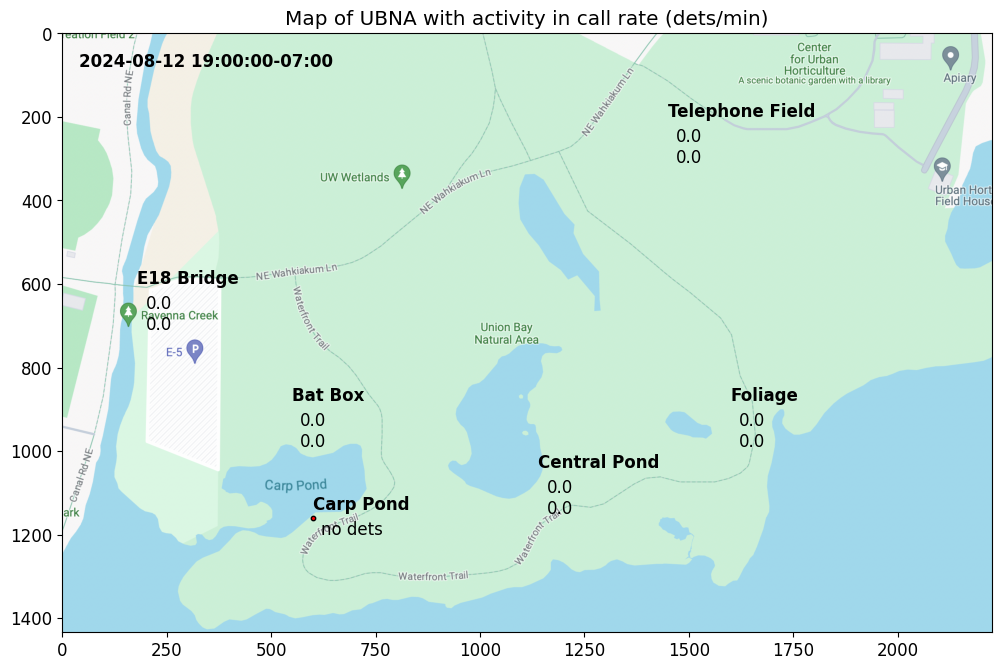

MovieWriter PillowWriter unavailable; using Pillow instead.


ValueError: need at least one array to concatenate

In [25]:
plot_title = f'{single_night.index[0].strftime("%Y%m%d")}_night_activity_1min_res'
print(plot_title)

# create figure object
fig = plt.figure(figsize=(12, 12))
ax = plt.axes()
plt.rcParams.update({'font.size':12})
# load axis box

camera = Camera(fig)
for date, site_calls in single_night.iterrows():
    img = plt.imread("../../Desktop/UBNA.jpg")
    ax.set_title('Map of UBNA with activity in call rate (dets/min)')
    ax.imshow(img)
    for site in sites:
        if not(np.isnan(single_night.loc[date][site])):            
            ax.text(x=site_locs[site][0],y=site_locs[site][-1]-20,s=site,fontweight='bold')

            ax.scatter(x=site_locs[site][0],y=site_locs[site][-1],s=single_night_LF.loc[date][site]/10,facecolor='cyan', edgecolor='k')
            ax.text(x=site_locs[site][0]+20,y=site_locs[site][-1]+40,s=f'{(round(single_night_LF.loc[date][site], 3))/5}')

            ax.scatter(x=site_locs[site][0],y=site_locs[site][-1]+50,s=single_night_HF.loc[date][site]/10,facecolor='orange', edgecolor='k')
            ax.text(x=site_locs[site][0]+20,y=site_locs[site][-1]+90,s=f'{(round(single_night_HF.loc[date][site], 3))/5}')
        else:
            ax.scatter(x=site_locs[site][0],y=site_locs[site][-1],s=10,facecolor='red', edgecolor='k')
            ax.text(x=site_locs[site][0],y=site_locs[site][-1]-20,s=site,fontweight='bold')
            ax.text(x=site_locs[site][0]+20,y=site_locs[site][-1]+40,s=f'no dets')
    
    ax.text(x=40,y=80,s=date,fontweight='bold')
    # plt.show()
    plt.pause(0.1)
    camera.snap()

animation = camera.animate()
animation.save(f'{plot_title}.gif', writer='PillowWriter', fps=2)